## 1. Data Synthesis

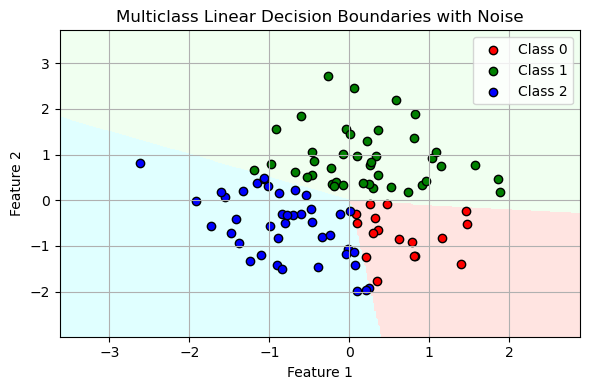

In [1]:
#First line now
import numpy as np
import matplotlib.pyplot as plt
import time

# Set a fixed random seed for reproducibility
np.random.seed(42)

# Parameters
n = 100  # total data points
k = 3
d = 2
noise_level = 0

# Step 1: Regenerate weight vectors and data
W = np.random.randn(k, d) * 5
X = np.random.randn(n,d)
X += noise_level * np.random.randn(*X.shape)

# Step 2: Assign labels
scores = X @ W.T
y = np.argmax(scores, axis=1)

# Step 3: Define colors for background and points
point_colors = ['red', 'green', 'blue']
bg_colors = ['mistyrose', 'honeydew', 'lightcyan']

# Step 4: Plot
plt.figure(figsize=(6, 4))

# Decision boundary background
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_scores = grid @ W.T
grid_pred = np.argmax(grid_scores, axis=1)
grid_pred = grid_pred.reshape(xx.shape)

for i, bg_color in enumerate(bg_colors):
    plt.contourf(xx, yy, grid_pred == i, levels=[0.5, 1], colors=[bg_color], alpha=1)

# Plot data points
for i in range(k):
    plt.scatter(X[y == i, 0], X[y == i, 1], c=point_colors[i], label=f"Class {i}", edgecolor='k')

plt.title("Multiclass Linear Decision Boundaries with Noise")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 2. Primal Solver

### Global function to compute Primal Loss

#### Crammer & Singer

In [2]:
def multiclassPrimalLoss(X, y, W, C):
    """
    Computes the Crammer-Singer multiclass SVM primal loss.

    Args:
        X: [n x d] data matrix
        y: [n] vector of true class labels
        W: [k x d] weight matrix (each row is a class weight vector)
        C: regularization constant

    Returns:
        float: value of the total loss
    """
    n = X.shape[0]
    k = W.shape[0]

    # Regularization term: 0.5 * sum of squared norms of each class weight
    reg = 0.5 * np.sum(W * W)

    # Hinge loss term
    loss = 0.0
    for i in range(n):
        x_i = X[i]
        y_i = y[i]
        correct_score = np.dot(W[y_i], x_i)

        # Compute the max margin violation among incorrect classes
        margins = [1 - (correct_score - np.dot(W[j], x_i)) for j in range(k) if j != y_i]
        # Vectorize similarly  for weston watkins losss
        loss += max(0, max(margins))

    return reg + C * loss

#### Weston-Watkins

In [3]:
def multiclassPrimalLoss(X, y, W, C):
    """
    Computes the Weston-Watkins multiclass SVM primal loss.

    Args:
        X: [n x d] data matrix
        y: [n] vector of true class labels
        W: [k x d] weight matrix (each row is a class weight vector)
        C: regularization constant

    Returns:
        float: value of the total Weston-Watkins loss
    """
    n = X.shape[0]
    k = W.shape[0]
    reg = 0.5 * np.sum(W * W)

    loss = 0.0 
    for i in range(n):
        x_i = X[i]
        y_i = y[i]
        correct_score = np.dot(W[y_i], x_i)

        # Sum over all incorrect classes
        for j in range(k):
            if j != y_i:
                margin = 1 - (correct_score - np.dot(W[j], x_i))
                if margin > 0:
                    loss += margin

    return reg + C * loss


### Primal Solver

In [4]:
# Updated MulticlassSVMSGDSolver with corrected regularization inside the weight updates

class MulticlassSVMSGDSolver:
    """
    Multiclass SVM solver using Stochastic Gradient Descent (Crammer-Singer formulation).

    Attributes:
        C (float): Regularization parameter.
        lr (float): Fixed learning rate.
        epochs (int): Number of training epochs.
        W (np.ndarray): Final optimized weight matrix.
        W_history (list): List of weight matrices per epoch.
        epoch_times (list): Computation durations per epoch.
        loss_history (list): Loss value at each epoch.
    """

    def __init__(self, C=1.0, lr=0.01, epochs=1000):
        self.C = C
        self.lr = lr
        self.epochs = epochs
        self.W = None
        self.W_history = []
        self.epoch_times = []
        self.loss_history = []

    def fit(self, X, y):
        """
        Trains the multiclass SVM using SGD with Crammer-Singer loss.

        Args:
            X (np.ndarray): Feature matrix of shape (n x d).
            y (np.ndarray): Labels of shape (n,) with values in {0, ..., k-1}.
        """
        n, d = X.shape
        k = np.max(y) + 1  # number of classes

        W = np.zeros((k, d))
        self.W_history = []
        self.epoch_times = []
        self.loss_history = []
        time_elapsed = 0

        for _ in range(self.epochs):
            start_time = time.perf_counter()

            for i in range(n):
                x_i = X[i]
                y_i = y[i]

                # Compute scores
                scores = W @ x_i  # shape: (k,)
                correct_score = scores[y_i]

                # Find the class with highest violating margin
                margins = scores + 1 - correct_score
                margins[y_i] = -np.inf  # exclude correct class
                # Change to all classes
                j_star = np.argmax(margins)

                # If violation exists, update
                if margins[j_star] > 0:
                    # Corrected: subtract regularization from W[y_i], and add gradient to W[j_star]
                    W[y_i] -= self.lr * (W[y_i] - self.C * x_i)
                    W[j_star] -= self.lr * (W[j_star] + self.C * x_i)

            time_delta = time.perf_counter() - start_time
            time_elapsed += time_delta

            self.W_history.append(W.copy())
            self.epoch_times.append(time_elapsed)

            # Compute and store loss
            loss = multiclassPrimalLoss(X, y, W, self.C)
            self.loss_history.append(loss)

        self.W = W
        return self

In [5]:
# Train multiclass SVM using SGD solver
primalSolver = MulticlassSVMSGDSolver(C=1, lr=0.01, epochs=100)
primalSolver.fit(X, y)

W_primal = primalSolver.W

# Print the optimized weight matrix
print("Optimized weight matrix using multiclass primal form:\n", W_primal)

Optimized weight matrix using multiclass primal form:
 [[ 0.17367808 -0.1317099 ]
 [ 0.24345039  0.51779121]
 [-0.42323268 -0.30124873]]


In [6]:
W

array([[ 2.48357077, -0.69132151],
       [ 3.23844269,  7.61514928],
       [-1.17076687, -1.17068478]])

### Decision Boundary

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plotDecisionBoundary(X, y, W, pointColors=None, bgColors=None, title="Multiclass Linear Decision Boundaries"):
    """
    Plots the decision boundary for a trained multiclass SVM model.

    Args:
        X (np.ndarray): Data matrix of shape (n, 2) for 2D features.
        y (np.ndarray): Labels of shape (n,) with values in {0, ..., K-1}.
        W (np.ndarray): Trained weight matrix of shape (K, 2).
        pointColors (list): List of colors for points per class.
        bgColors (list): List of background colors for regions per class.
        title (str): Title of the plot.
    """
    if pointColors is None:
        pointColors = ['red', 'green', 'blue']
    if bgColors is None:
        bgColors = ['mistyrose', 'honeydew', 'lightcyan']

    K = W.shape[0]

    # Create mesh grid for plotting
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Predict on grid
    grid_scores = grid @ W.T
    grid_pred = np.argmax(grid_scores, axis=1).reshape(xx.shape)

    # Plot background decision regions
    plt.figure(figsize=(6, 5))
    for i, bg_color in enumerate(bgColors):
        plt.contourf(xx, yy, grid_pred == i, levels=[0.5, 1], colors=[bg_color], alpha=1)

    # Plot data points
    for i in range(K):
        plt.scatter(X[y == i, 0], X[y == i, 1], c=pointColors[i], label=f"Class {i}", edgecolor='k')

    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


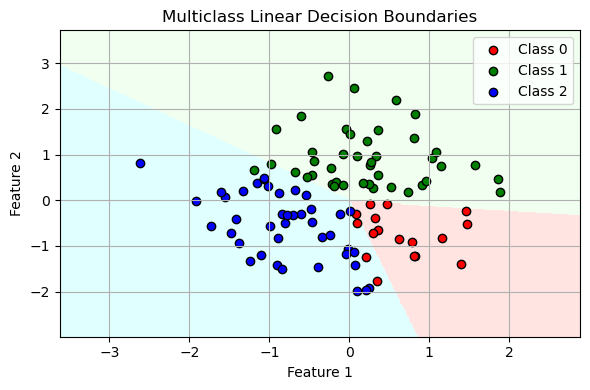

In [8]:
plotDecisionBoundary(X, y, W_primal)

## 3. Dual Solver

### Solver

In [9]:
class WestonWatkinsDualSolver:
    def __init__(self, C=1.0, M=1.0, epochs=10):
        self.C = C
        self.M = M
        self.epochs = epochs
        self.alpha = None
        self.W = None
        self.alpha_history = []
        self.W_history = []
        self.epoch_times = []
        self.loss_history = []

    def fit(self, X, y):
        n, d = X.shape
        K = np.max(y) + 1
        alpha = np.zeros((n, K))
        W = np.zeros((K, d))
        x_norms_squared = np.sum(X ** 2, axis=1)
        time_elapsed = 0

        for epoch in range(self.epochs):
            start = time.perf_counter()

            for i in range(n):
                x_i = X[i]
                y_i = y[i]
                norm_x_i_sq = x_norms_squared[i]

                for j in range(K):
                    if j == y_i:
                        continue

                    # Gradient and step
                    g = self.M * (np.dot(W[y_i], x_i) - np.dot(W[j], x_i)) - 1
                    eta = self.M ** 2 * norm_x_i_sq
                    m = -g / (2 * eta)

                    # Clipped update
                    alpha_old = alpha[i, j]
                    alpha_new = np.clip(alpha_old + m, 0, self.C)
                    delta = alpha_new - alpha_old
                    if delta == 0:
                        continue

                    alpha[i, j] = alpha_new
                    alpha[i, y_i] = -np.sum(alpha[i, np.arange(K) != y_i])

                    # Incremental W update
                    W[j] -= self.M * delta * x_i
                    W[y_i] += self.M * delta * x_i

            time_elapsed += time.perf_counter() - start
            self.alpha_history.append(alpha.copy())
            self.W_history.append(W.copy())
            self.epoch_times.append(time_elapsed)

            # Compute primal loss (outside timed block)
            primal_loss = multiclassPrimalLoss(X, y, W, self.C)
            self.loss_history.append(primal_loss)

        self.alpha = self.alpha_history[-1]
        self.W = self.W_history[-1]
        return self

### Train

In [10]:
# Create and train the Weston-Watkins dual solver
dualSolver = WestonWatkinsDualSolver(C=1.0, M=1.0, epochs=100)
dualSolver.fit(X, y)

# Access trained weight matrix
W_dual = dualSolver.W

# Print final primal loss
print("Final Primal Loss from Dual Solver:", dualSolver.loss_history[-1])

# Print final cumulative optimization time
print("Total Optimization Time:", dualSolver.epoch_times[-1], "seconds")

Final Primal Loss from Dual Solver: 21.95195725123449
Total Optimization Time: 0.3050906000571558 seconds


### Decision Boundary

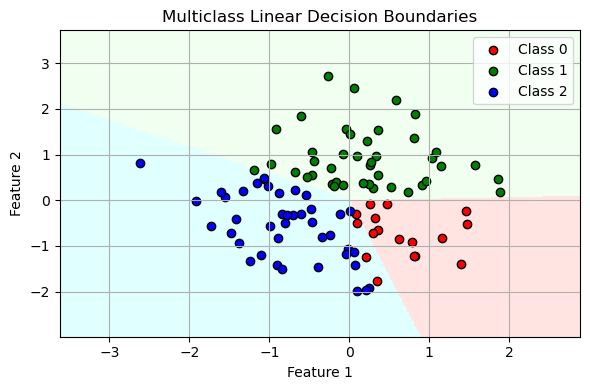

In [11]:
plotDecisionBoundary(X, y, W_dual)

## 3. Simplex Projection Dual

1. Primal optimization problem (Crammer-Singer multiclass SVM)
$$
\min_{\{w_m\}_{m=1}^k} \frac{1}{2} \sum_{m=1}^k \|w_m\|^2 + C \sum_{i=1}^n \left[1 + \max_{m \ne y_i} w_m^\top x_i - w_{y_i}^\top x_i \right]_+
$$
\
2. Slack variable form (equivalent primal with constraints)
$$
\min_{\{w_m\}, \{\xi_i\}} \frac{1}{2} \sum_{m=1}^k \|w_m\|^2 + C \sum_{i=1}^n \xi_i
\quad \text{s.t. } w_{y_i}^\top x_i - w_m^\top x_i \ge 1 - \xi_i,\ \forall m \ne y_i
$$
\
3. Dual formulation (from Lagrangian dualization)
$$
\min_{\alpha} f(\alpha) = \frac{1}{2} \sum_{m=1}^k \left\| \sum_{i=1}^n \alpha_i^m x_i \right\|^2 + \sum_{i=1}^n \sum_{m=1}^k \Delta_i^m \alpha_i^m
$$
$$
\text{subject to: } \sum_{m=1}^k \alpha_i^m = 0, \quad \alpha_i^m \le C_i^m
$$\
$$
\Delta_i^m = 0 \text{ if } m=y_i \text { else} 1
$$
4. Gradient of the dual objective (used in optimization loop)
$$
g_i^m = w_m^\top x_i + \Delta_i^m
$$
\
5. Restricted subproblem (per-example optimization in dual decomposition)
$$
\min_{\delta_i \in \mathbb{R}^k} \frac{1}{2} \|\delta_i\|^2 + g_i^\top \delta_i
\quad \text{subject to: } \delta_i^\top \mathbf{1} = 0,\ \delta_i \le C_i - \alpha_i
$$
\
6. Change of variables: reducing to simplex projection
$$
\delta_i = C_i - \alpha_i - \frac{\beta}{\|x_i\|} 
\quad \Rightarrow \quad \beta = \|x_i\| (C_i - \alpha_i - \delta_i)
$$

7. Final equivalent problem: Euclidean projection onto simplex
$$
\min_{\beta \in \mathbb{R}^k} \frac{1}{2} \|\beta - \hat{\beta}\|^2 
\quad \text{subject to: } \beta \ge 0, \quad \sum_{m=1}^k \beta_m = z
$$
Where:
$$
\hat{\beta} = \|x_i\|(C_i - \alpha_i) + \frac{g_i}{\|x_i\|}, 
\quad z = C \cdot \|x_i\|
$$

### Solver

In [12]:
import numpy as np
import time

class BlondelMulticlassSVMDualSolver:
    def __init__(self, C=1.0, epochs=10, epsilon=1e-3):
        self.C = C
        self.epochs = epochs
        self.epsilon = epsilon
        self.alpha = None
        self.W = None
        self.alpha_history = []
        self.W_history = []
        self.epoch_times = []
        self.loss_history = []

    def _compute_gradient(self, W, x_i, y_i, K):
        g = W @ x_i
        g += 1  # add 1 everywhere
        g[y_i] -= 1  # correct class: g[y_i] = w_yi^T x_i
        return g

    def _compute_violation(self, g, alpha_i, C_i):
        max_g = np.max(g)
        min_g = np.min([g[m] for m in range(len(g)) if alpha_i[m] < C_i[m]])
        return max_g - min_g

    def _simplex_projection(self, v, z):
        """Project v onto the simplex {x | x >= 0, sum x = z}"""
        u = np.sort(v)[::-1]
        cssv = np.cumsum(u)
        rho = np.nonzero(u * np.arange(1, len(v)+1) > (cssv - z))[0][-1]
        theta = (cssv[rho] - z) / (rho + 1.0)
        w = np.maximum(v - theta, 0)
        return w

    def fit(self, X, y):
        n, d = X.shape
        K = np.max(y) + 1
        alpha = np.zeros((n, K))
        W = np.zeros((K, d))
        x_norms_squared = np.sum(X ** 2, axis=1)
        time_elapsed = 0

        for epoch in range(self.epochs):
            start = time.perf_counter()
            vmax = 0

            for i in range(n):
                x_i = X[i]
                y_i = y[i]
                norm_x_i = np.sqrt(x_norms_squared[i])

                g_i = self._compute_gradient(W, x_i, y_i, K)
                v_i = self._compute_violation(g_i, alpha[i], np.where(np.arange(K) == y_i, self.C, 0))
                vmax = max(vmax, v_i)
                
                #Why sample is skipped if no violation ?
                if v_i <= self.epsilon:
                    continue

                C_i = np.where(np.arange(K) == y_i, self.C, 0)
                beta_hat = norm_x_i * (C_i - alpha[i]) + g_i / norm_x_i
                z = self.C * norm_x_in
                beta_proj = self._simplex_projection(beta_hat, z)
                delta_i = C_i - alpha[i] - beta_proj / norm_x_i

                alpha[i] += delta_i
                for m in range(K):
                    W[m] += delta_i[m] * x_i

            time_elapsed += time.perf_counter() - start
            self.alpha_history.append(alpha.copy())
            self.W_history.append(W.copy())
            self.epoch_times.append(time_elapsed)
            
            # Compute primal loss (outside timed block)
            primal_loss = multiclassPrimalLoss(X, y, W, self.C)
            self.loss_history.append(primal_loss)

        self.alpha = self.alpha_history[-1]
        self.W = self.W_history[-1]
        return self

In [13]:
# Create and train the Weston-Watkins dual solver
dualSolverBlondel = BlondelMulticlassSVMDualSolver(C=1.0, epochs=100)
dualSolverBlondel.fit(X, y)

# Access trained weight matrix
W_dual_Blondel = dualSolverBlondel.W

# Print final primal loss
print("Final Primal Loss from Dual Solver:", dualSolverBlondel.loss_history[-1])

# Print final cumulative optimization time
print("Total Optimization Time:", dualSolverBlondel.epoch_times[-1], "seconds")

Final Primal Loss from Dual Solver: 21.953139565132663
Total Optimization Time: 0.45400080001854803 seconds


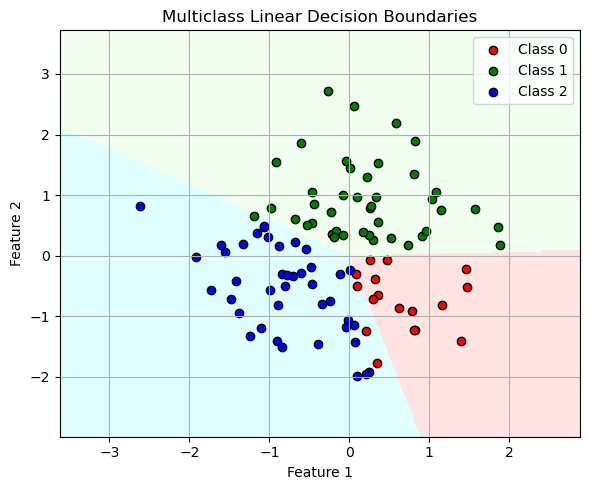

In [20]:
plotDecisionBoundary(X, y, W_dual_Blondel)

## 4. Time Comparision

In [15]:
import matplotlib.pyplot as plt

def plotLossHistory(model_sgd, model_dual):
    """
    Plots the primal loss history over cumulative epoch time for both
    the SGD and dual multiclass SVM solvers.

    Args:
        model_sgd: Trained MulticlassSVMSGDSolver instance.
        model_dual: Trained WestonWatkinsDualSolver instance.
    """
    # SGD history
    loss_sgd = model_sgd.loss_history
    epoch_times_sgd = model_sgd.epoch_times

    # Dual history
    loss_dual = model_dual.loss_history
    epoch_times_dual = model_dual.epoch_times

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(epoch_times_sgd, loss_sgd, label='SGD Solver', marker='x')
    plt.plot(epoch_times_dual, loss_dual, label='Dual Solver', marker='o')

    plt.yscale("linear")
    plt.xlabel('Cumulative Epoch Time (s)')
    plt.ylabel('Primal Loss')
    plt.title('Loss vs Epoch Time for Multiclass SVM Solvers')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

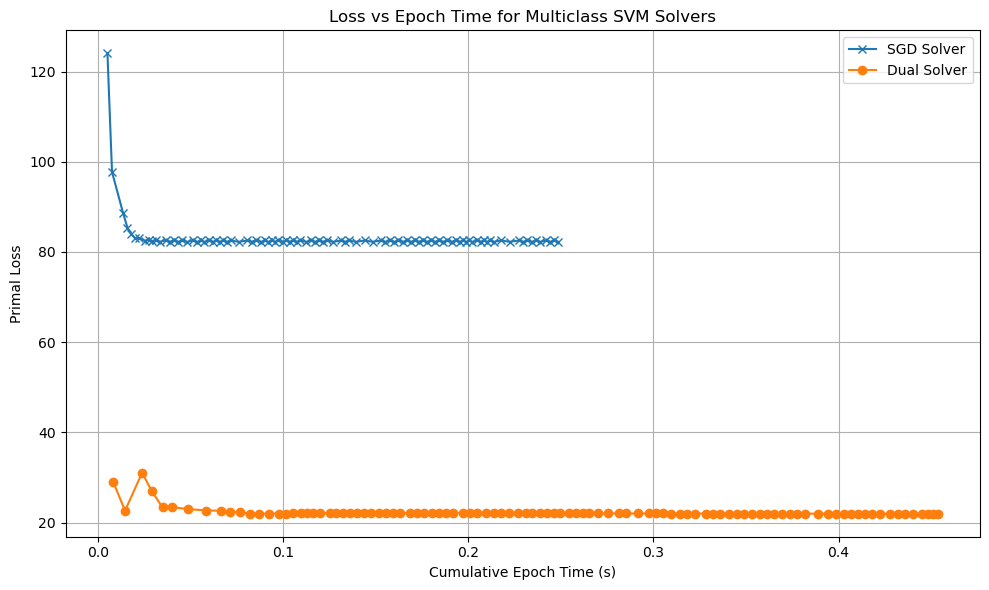

In [16]:
plotLossHistory(primalSolver,dualSolverBlondel)

In [17]:
def computeAccuracy(X, y, W):
    preds = np.argmax(X @ W.T, axis=1)
    return np.mean(preds == y)

In [18]:
y_pred_primal = np.argmax(X @ W_primal.T, axis=1)
y_pred_dual = np.argmax(X @ W_dual_Blondel.T, axis=1)
print("Primal Solver Accuracy:", np.mean(y_pred_primal == y))
print("Dual Solver Accuracy:", np.mean(y_pred_dual == y))

Primal Solver Accuracy: 0.95
Dual Solver Accuracy: 0.95
